In [2]:
import warnings
warnings.filterwarnings("ignore")

import os, pandas as pd, matplotlib.pyplot as plt, numpy as np, seaborn as sns, scipy.stats as stats, glob
from pynwb import NWBHDF5IO
from pathlib import Path
from convnwb.io import load_nwbfile

from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
# import phate
from scipy.interpolate import interp1d

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from scipy.stats import pearsonr, spearmanr

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from statsmodels.api import GLM
from statsmodels.genmod.families import Gaussian
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from matplotlib.lines import Line2D
from scipy.ndimage import gaussian_filter1d
import random


## confirm number of subjects, neurons, trials

In [3]:
# norm_choice = 'shortest_baseline'
# norm_choice = 'session_baseline'
norm_choice = 'self'
# norm_choice = 'nothing'
print(f'df normalized by {norm_choice}\n')

df = pd.read_pickle(f'./data_files/neuron_by_trial_norm_by_{norm_choice}.pkl')
print(f'{df["neuron"].nunique()} total neurons\n')

# identify neurons with zero firing rate in encoding or baseline
zero_FR_neurs = df[(df['FR'] == 0) & (df['stim_phase'].isin(['encoding', 'baseline']))]['neuron'].unique()
print(f'{len(zero_FR_neurs)} neurs dropped because FR = 0 in encoding or baseline: {zero_FR_neurs}\n')

# drop these neurs
df_filtered = df[~df['neuron'].isin(zero_FR_neurs)]
df_encoding = df_filtered[df_filtered['stim_phase'] == 'encoding']
num_subjs, num_sess, num_neurons = len(np.unique(df_encoding['subj'])), len(np.unique(df_encoding['sess'])), len(np.unique(df_encoding['neuron']))

print(f'{num_neurons} neurons, {num_sess} sessions, {num_subjs} subjects')
print(f'{len(df_encoding)} rows in df\n')

no_fMRI_subjs = ['P49', 'P55', 'P56', 'P57', 'P58']
print(f'subjs who didnt undergo fMRI: {no_fMRI_subjs}\n')

scene_cells = ['P42CS_R1_47_2_1347_7', 'P42CS_R2_42_3_1096_7', 'P43CS_R1_59_3_1929_1', 'P43CS_R1_76_4_1276_10', 'P43CS_R2_29_1_2303_2',
               'P44CS_R1_15_2_835_8', 'P47CS_R1_10_2_900_8', 'P47CS_R1_18_1_1631_4', 'P47CS_R1_22_4_1379_4', 'P47CS_R1_68_1_964_9',
               'P47CS_R1_74_2_1575_10', 'P47CS_R1_78_1_2233_10', 'P47CS_R2_19_2_3139_4', 'P47CS_R2_20_4_2437_4', 'P47CS_R2_47_1_1478_7',
               'P48CS_R1_9_1_678_8', 'P48CS_R1_21_2_873_4', 'P48CS_R1_30_1_1720_2', 'P48CS_R1_43_2_3181_7', 'P48CS_R2_48_2_936_7',
               'P48CS_R2_58_8_6571_1', 'P49CS_R1_7_1_2581_6', 'P49CS_R2_67_1_1165_10', 'P51CS_R1_48_1_2072_8', 'P51CS_R2_40_3_2542_5',
               'P51CS_R2_80_1_794_9', 'P53CS_R1_10_1_2456_8', 'P53CS_R2_6_4_5480_6', 'P53CS_R2_16_2_6444_8', 'P54CS_R1_17_2_3943_4',
               'P54CS_R1_45_1_2172_7', 'P54CS_R1_54_3_4177_3', 'P54CS_R1_55_2_6861_3', 'P54CS_R1_56_1_1540_3', 'P54CS_R1_70_3_5181_10',
               'P54CS_R2_13_4_7736_8', 'P54CS_R2_67_1_4703_10', 'P55CS_R2_18_2_1050_4', 'P55CS_R2_45_1_1206_7', 'P55CS_R2_48_1_36_7',
               'P56CS_R1_9_1_3423_8', 'P56CS_R1_13_1_999_8', 'P56CS_R1_19_1_1458_4', 'P57CS_R1_66_1_2442_10', 'P57CS_R2_9_1_740_8',
               'P57CS_R2_15_2_1738_8', 'P57CS_R2_70_2_1978_10', 'P58CS_R1_34_3_3299_5', 'P58CS_R1_34_4_3301_5', 'P58CS_R1_35_4_2476_5',
               'P58CS_R1_56_1_3134_3', 'P58CS_R1_57_3_2783_1', 'P58CS_R1_60_1_1424_1', 'P58CS_R1_62_2_3305_1', 'P58CS_R1_63_2_3170_1',
               'P60CS_R1_39_1_1408_5', 'P60CS_R1_54_1_571_3', 'P60CS_R1_56_1_1106_3', 'P62CS_R1_30_3_6240_3', 'P62CS_R2_22_2_2532_7']

memory_cells = ['P42CS_R1_35_2_933_5', 'P42CS_R1_38_2_1356_5', 'P42CS_R1_47_2_1347_7', 'P42CS_R1_48_1_1363_7', 'P42CS_R2_34_3_1494_5',
                'P42CS_R2_38_2_1367_5', 'P42CS_R2_39_2_1407_5', 'P42CS_R2_52_1_453_3', 'P42CS_R2_57_1_449_1', 'P43CS_R1_59_2_1920_1',
                'P43CS_R1_61_2_2249_1', 'P43CS_R1_77_1_575_10', 'P43CS_R2_63_1_2357_1', 'P43CS_R2_64_1_1745_1', 'P43CS_R2_74_2_2642_10',
                'P47CS_R1_20_3_481_4', 'P47CS_R1_23_1_654_4', 'P47CS_R1_24_1_612_4', 'P47CS_R1_51_1_1091_3', 'P47CS_R2_23_3_2979_4',
                'P47CS_R2_43_1_1433_7', 'P47CS_R2_46_2_3015_7', 'P47CS_R2_52_2_2453_3', 'P47CS_R2_54_1_3260_3', 'P47CS_R2_68_1_2752_9',
                'P47CS_R2_69_2_4689_9', 'P47CS_R2_74_1_4862_10', 'P47CS_R2_75_2_2140_10', 'P48CS_R1_6_1_395_6', 'P48CS_R1_33_1_1922_5',
                'P48CS_R1_34_1_1509_5', 'P48CS_R1_34_3_1588_5', 'P48CS_R1_36_1_3275_5', 'P48CS_R1_39_1_1970_5', 'P48CS_R1_44_2_3419_7',
                'P48CS_R1_52_1_766_3', 'P48CS_R1_58_1_5195_1', 'P48CS_R2_33_1_741_5', 'P48CS_R2_36_3_853_5', 'P48CS_R2_37_1_662_5',
                'P48CS_R2_40_1_509_5', 'P48CS_R2_41_2_2328_7', 'P48CS_R2_42_1_1164_7', 'P48CS_R2_56_4_1217_3', 'P48CS_R2_63_1_2064_1',
                'P48CS_R2_63_3_2076_1', 'P48CS_R2_64_1_1208_1', 'P49CS_R2_47_1_913_7', 'P51CS_R1_36_1_960_6', 'P51CS_R1_39_1_604_6',
                'P53CS_R1_11_1_3077_8', 'P53CS_R1_43_2_2012_7', 'P53CS_R2_2_2_3157_6', 'P53CS_R2_13_2_4578_8', 'P54CS_R1_22_2_4855_4',
                'P54CS_R1_41_1_4796_7', 'P54CS_R1_44_1_4930_7', 'P54CS_R1_65_2_5598_10', 'P54CS_R1_67_2_4601_10', 'P54CS_R2_17_1_1062_4',
                'P54CS_R2_17_3_2751_4', 'P54CS_R2_17_5_2816_4', 'P54CS_R2_27_6_2115_2', 'P54CS_R2_70_1_3529_10', 'P54CS_R2_73_1_2011_9',
                'P54CS_R2_77_2_2110_9', 'P55CS_R1_18_2_3208_4', 'P55CS_R1_43_1_3299_7', 'P55CS_R1_53_1_6042_3', 'P55CS_R1_53_3_6124_3',
                'P55CS_R1_56_1_2091_3', 'P55CS_R1_68_1_7817_10', 'P55CS_R2_23_2_966_4', 'P55CS_R2_24_1_754_4', 'P55CS_R2_53_1_991_3',
                'P55CS_R2_66_1_1522_10', 'P56CS_R1_10_1_1498_8', 'P58CS_R1_5_1_1545_6', 'P58CS_R1_23_1_3462_4', 'P58CS_R1_23_2_3466_4',
                'P58CS_R1_24_1_2565_4', 'P58CS_R1_26_1_2741_2', 'P58CS_R1_34_2_3239_5', 'P58CS_R1_35_4_2476_5', 'P58CS_R1_38_1_1473_5',
                'P58CS_R1_60_2_1572_1', 'P58CS_R1_62_1_3216_1', 'P58CS_R1_62_3_3313_1', 'P60CS_R1_50_1_819_3', 'P60CS_R1_78_1_599_9',
                'P62CS_R1_18_2_3846_7', 'P62CS_R1_22_2_2532_7', 'P62CS_R1_25_1_3438_3', 'P62CS_R1_27_7_8732_3', 'P62CS_R2_25_1_3438_3',
                'P62CS_R2_25_3_3529_3', 'P62CS_R2_32_2_5965_3', 'P62CS_R2_32_4_6011_3', 'P62CS_R2_32_6_6115_3']

sessions_with_scene_cells = np.unique([cell[:8] for cell in scene_cells])
print(f'{len(sessions_with_scene_cells)} sessions with scene cells: {sessions_with_scene_cells}\n')

print(f'{len(scene_cells)} scene selective cells')

# drop certian cols
df_encoding = df_encoding.drop(columns=['start_time', 'stop_time', 'stim_phase', 'stimulus_file', 'trial_smooth_FR',
       'response_correct', 'response_confidence', 'actual_response']).reset_index(drop=True)

df_encoding.head()


df normalized by self

1457 total neurons

19 neurs dropped because FR = 0 in encoding or baseline: ['P43CS_R2_76_1_990_10' 'P47CS_R1_19_4_1280_4' 'P47CS_R1_52_1_298_3'
 'P47CS_R2_22_1_8375_4' 'P48CS_R1_24_1_2297_4' 'P48CS_R1_57_1_753_1'
 'P48CS_R2_58_3_6420_1' 'P48CS_R2_62_2_2097_1' 'P49CS_R2_64_1_4257_1'
 'P51CS_R2_48_4_5337_7' 'P53CS_R1_37_1_3731_5' 'P54CS_R1_70_2_5145_10'
 'P54CS_R2_31_1_2534_2' 'P55CS_R1_49_2_5469_3' 'P55CS_R1_54_1_3978_3'
 'P57CS_R2_51_1_624_3' 'P62CS_R1_27_3_8498_3' 'P62CS_R1_29_3_8468_3'
 'P62CS_R1_32_6_6115_3']

1438 neurons, 29 sessions, 16 subjects
1438 rows in df

subjs who didnt undergo fMRI: ['P49', 'P55', 'P56', 'P57', 'P58']

25 sessions with scene cells: ['P42CS_R1' 'P42CS_R2' 'P43CS_R1' 'P43CS_R2' 'P44CS_R1' 'P47CS_R1'
 'P47CS_R2' 'P48CS_R1' 'P48CS_R2' 'P49CS_R1' 'P49CS_R2' 'P51CS_R1'
 'P51CS_R2' 'P53CS_R1' 'P53CS_R2' 'P54CS_R1' 'P54CS_R2' 'P55CS_R2'
 'P56CS_R1' 'P57CS_R1' 'P57CS_R2' 'P58CS_R1' 'P60CS_R1' 'P62CS_R1'
 'P62CS_R2']

60 scene selective ce

,subj,sess,neuron,region,RT,trial_spikes,trial_aligned_spikes,num_spikes,FR,trial_smooth_spikes
0,P41,P41CS_R1,P41CS_R1_21_1_679_4,amygdala,478.85512,"[3.43207675, 4.39507675, 5.16801325, 5.2624507...","[3.43207675, 4.39507675, 5.16801325, 5.2624507...",360,0.751793,"[-1.2730946020175409, -0.710811152793127, -0.1..."
1,P41,P41CS_R1,P41CS_R1_38_1_613_5,ACC,478.85512,"[0.2510465, 2.07970175, 4.70126325, 5.09220075...","[0.2510465, 2.07970175, 4.70126325, 5.09220075...",278,0.580551,"[0.1727115902171085, -0.4970723816004588, 0.17..."
2,P41,P41CS_R1,P41CS_R1_39_1_1359_5,ACC,478.85512,"[0.3880465, 1.5347965, 1.61257775, 2.0414215, ...","[0.3880465, 1.5347965, 1.61257775, 2.0414215, ...",949,1.981810,"[-0.4841462836799911, -0.7340789431121942, -0...."
3,P41,P41CS_R1,P41CS_R1_40_1_2816_5,ACC,478.85512,"[0.0642965, 0.80051525, 0.813359, 0.89145275, ...","[0.0642965, 0.80051525, 0.813359, 0.89145275, ...",1820,3.800732,"[-1.277785091028816, -1.9862354843888455, -0.8..."
4,P41,P41CS_R1,P41CS_R1_40_2_2821_5,ACC,478.85512,"[0.4351715, 0.88882775, 1.79107775, 3.7156705,...","[0.4351715, 0.88882775, 1.79107775, 3.7156705,...",379,0.791471,"[0.3583427024917564, -0.2133277626874002, -0.7..."


## drop neurons with >16s blocks of no spikes

In [4]:
neurs_to_drop = []
missing_block_sz = 16 # time chunks of recording neurons

# loop through each neuron row in df_encoding
for neur_idx, neur_row in df_encoding.iterrows():

    # get recording duration and spikes for the current neuron
    RT = int(neur_row['RT'])
    spike_train = np.array(neur_row['trial_aligned_spikes'])
    
    # go through trial to find empty blocks
    t1 = 0
    while t1 < RT - missing_block_sz:

        block_spikes = spike_train[(t1 <= spike_train) & (spike_train < t1 + missing_block_sz)]

        if not np.any(block_spikes):
            neurs_to_drop.append(neur_idx)
            break

        t1 += 1

missing_spikes_neurs = df_encoding.loc[neurs_to_drop, 'neuron'].tolist()
print(f'{len(df_encoding)} total neurons')
df_encoding = df_encoding.drop(neurs_to_drop).reset_index(drop=True)
print(f'{len(neurs_to_drop)} dropped neurons: {missing_spikes_neurs}')
print(f'{len(df_encoding)} retained neurons')
print(df_encoding.groupby('region').size())

1438 total neurons
392 dropped neurons: ['P41CS_R1_70_1_1117_9', 'P41CS_R2_70_1_1117_9', 'P41CS_R2_71_1_1717_9', 'P42CS_R1_34_1_1294_5', 'P42CS_R1_34_2_1313_5', 'P42CS_R1_37_2_1190_5', 'P42CS_R1_38_1_1349_5', 'P42CS_R1_38_3_1432_5', 'P42CS_R1_42_1_667_7', 'P42CS_R1_42_2_768_7', 'P42CS_R1_42_3_813_7', 'P42CS_R1_47_3_1373_7', 'P42CS_R1_56_1_727_3', 'P42CS_R2_33_1_1163_5', 'P42CS_R2_38_1_949_5', 'P42CS_R2_39_3_1410_5', 'P42CS_R2_48_3_1100_7', 'P42CS_R2_54_1_1261_3', 'P43CS_R1_61_2_2249_1', 'P43CS_R1_62_2_2790_1', 'P43CS_R1_73_1_372_10', 'P43CS_R1_73_2_530_10', 'P43CS_R1_74_1_2638_10', 'P43CS_R1_76_1_990_10', 'P43CS_R1_76_2_1227_10', 'P43CS_R1_76_4_1276_10', 'P43CS_R1_77_1_575_10', 'P43CS_R2_73_1_372_10', 'P43CS_R2_74_1_2638_10', 'P43CS_R2_76_4_1276_10', 'P44CS_R1_1_1_1685_6', 'P44CS_R1_1_2_1700_6', 'P44CS_R1_3_1_599_6', 'P44CS_R1_3_2_1497_6', 'P44CS_R1_3_3_1530_6', 'P44CS_R1_4_1_1154_6', 'P44CS_R1_5_1_1287_6', 'P44CS_R1_6_1_1511_6', 'P44CS_R1_6_2_1515_6', 'P44CS_R1_6_3_1521_6', 'P44CS_R1_

## setting up some plotting vars

In [5]:
num_bins = len(df_encoding['trial_smooth_spikes'].iloc[0])
x_time_points = np.linspace(1, np.max(df_encoding['RT']), num_bins)
color_map = {'ACC': 'purple', 'amygdala': 'green', 'hippocampus': 'blue', 'preSMA': 'red', 'vmPFC': 'orange'}

## re-smoothing & normalizing (by self)

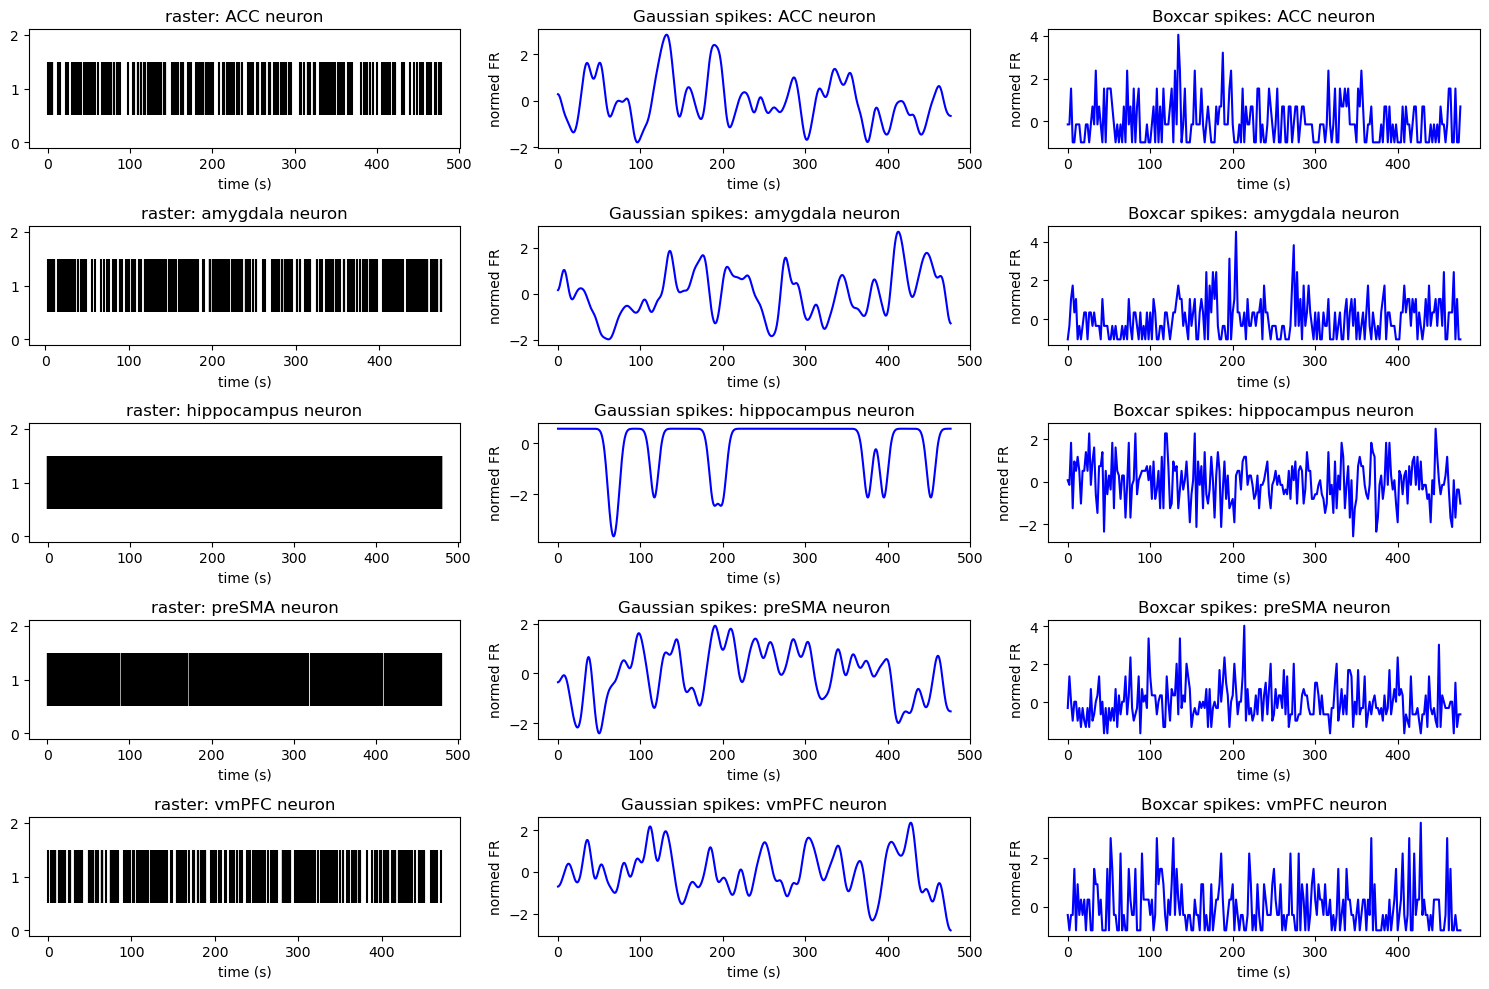

In [6]:
dur = 477 # s

# gaussian params
kernel_sd, dt = 1.5, .5 # kinda like bin_size and step
kernel_sd, dt = 5, .5 # kinda like bin_size and step
n_bins = int(dur / dt)
gauss_smooths = []

# no-overlap boxcar param
win_size = 2
boxcar_smooths = []

for spikes in df_encoding['trial_aligned_spikes']:
    
    # 1. gaussian filter

    t_gauss = np.arange(0, dur, dt)
    spike_train = np.zeros_like(t_gauss)
    
    # bin spikes
    inds = (np.array(spikes) / dt).astype(int) # what bins does each spikes fall into?
    inds = inds[inds < len(t_gauss)]
    spike_train[inds] = 1

    gauss_smooth = gaussian_filter1d(spike_train, sigma=kernel_sd/dt) / dt
    
    # norm
    mean, sd = np.nanmean(gauss_smooth), np.nanstd(gauss_smooth)
    gauss_normed = (gauss_smooth - mean) / sd if sd > 0 else gauss_smooth 
    gauss_smooths.append(gauss_normed)


    # 2. boxcar filter

    t_box = np.arange(0, dur, win_size)
    boxcar_smooth = []
    
    for i in np.arange(0, dur-win_size+win_size, win_size):
        boxcar_smooth.append(len(spikes[(spikes >= i) & (spikes < i + win_size)]))

    # norm
    mean, sd = np.nanmean(boxcar_smooth), np.nanstd(boxcar_smooth)
    boxcar_normed = (boxcar_smooth - mean) / sd if sd > 0 else boxcar_smooth
    boxcar_smooths.append(boxcar_normed)

df_encoding['gauss_smooths'] = gauss_smooths
df_encoding['boxcar_smooths'] = boxcar_smooths

num_neurs = 5
fig, axs = plt.subplots(num_neurs, 3, figsize=(15, 2 * num_neurs))
axs, ax = axs.flatten(), 0

for region, region_df in df_encoding.groupby('region'):

    # raster
    axs[ax].eventplot(region_df['trial_aligned_spikes'].iloc[0], color='black')
    axs[ax].set_title(f'raster: {region} neuron')
    axs[ax].set_xlabel('time (s)')
    ax += 1
    
    # gauss smooth
    axs[ax].plot(t_gauss, region_df['gauss_smooths'].iloc[0], color='blue')
    axs[ax].set_title(f'Gaussian spikes: {region} neuron')
    axs[ax].set_xlabel('time (s)')
    axs[ax].set_ylabel('normed FR')
    ax += 1

    # boxcar smooth
    axs[ax].plot(t_box, region_df['boxcar_smooths'].iloc[0], color='blue')
    axs[ax].set_title(f'Boxcar spikes: {region} neuron')
    axs[ax].set_xlabel('time (s)')
    axs[ax].set_ylabel('normed FR')
    ax += 1

plt.tight_layout()
plt.show()

## plot all neurons by region

IndexError: index 476 is out of bounds for axis 0 with size 5

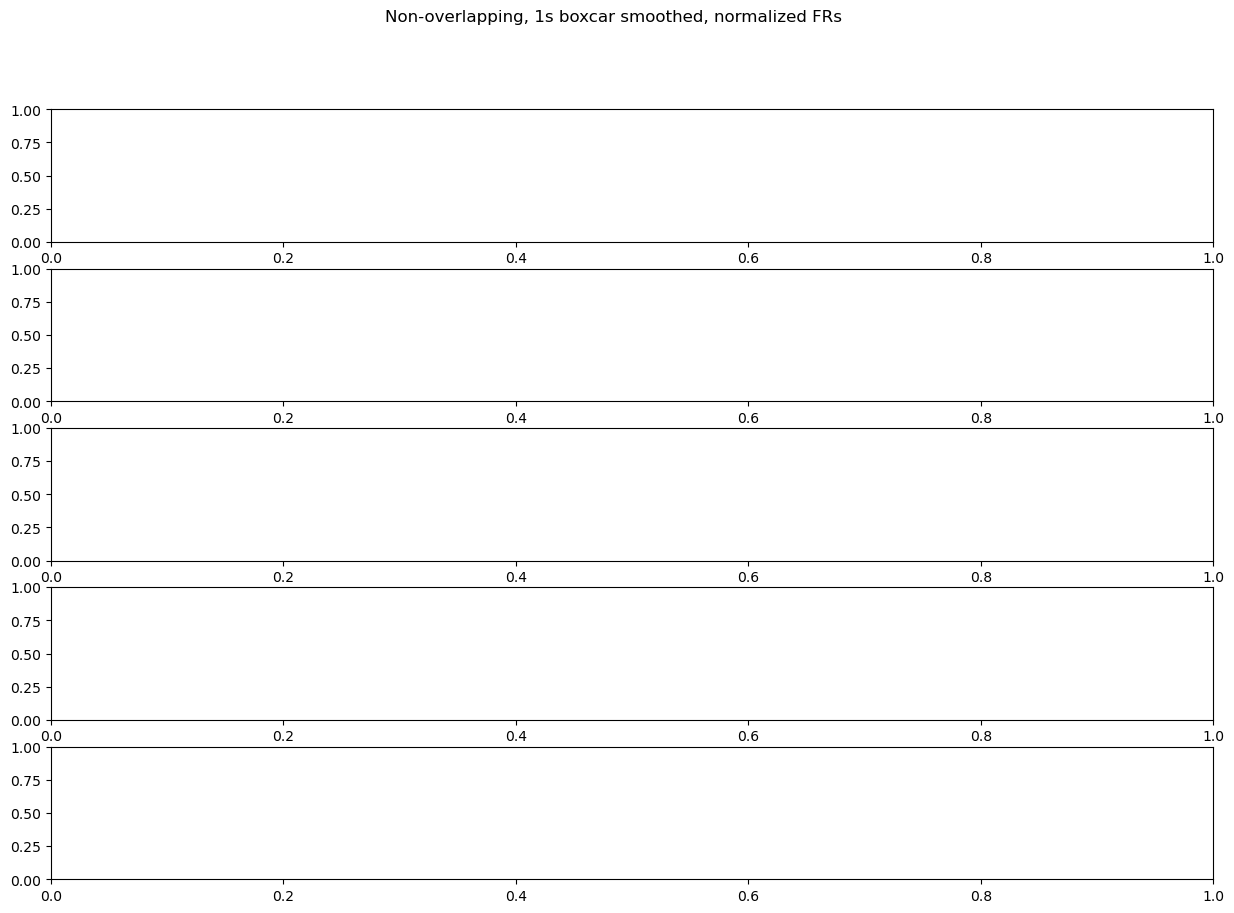

In [14]:
fig, ax = plt.subplots(5, 1, figsize=(15, 10))
axs, ax = ax.flatten(), 0
# suptitle
fig.suptitle(f'Non-overlapping, 1s boxcar smoothed, normalized FRs')

for region, region_df in df_encoding.groupby('region'):

    for row, neuron in region_df.iterrows():
        axs[i].plot(neuron['gauss_smooths'], color='blue', alpha=0.3)  # alpha to reduce overplotting

    axs[i].set_title(region)
    axs[ax].plot(t_gauss, region_df['gauss_smooths'].iloc[0], color='blue')
    axs[ax].set_xlabel('time (s)')
    axs[ax].set_ylabel('FR (Hz)')
    ax += 1
    
plt.tight_layout()
plt.show()

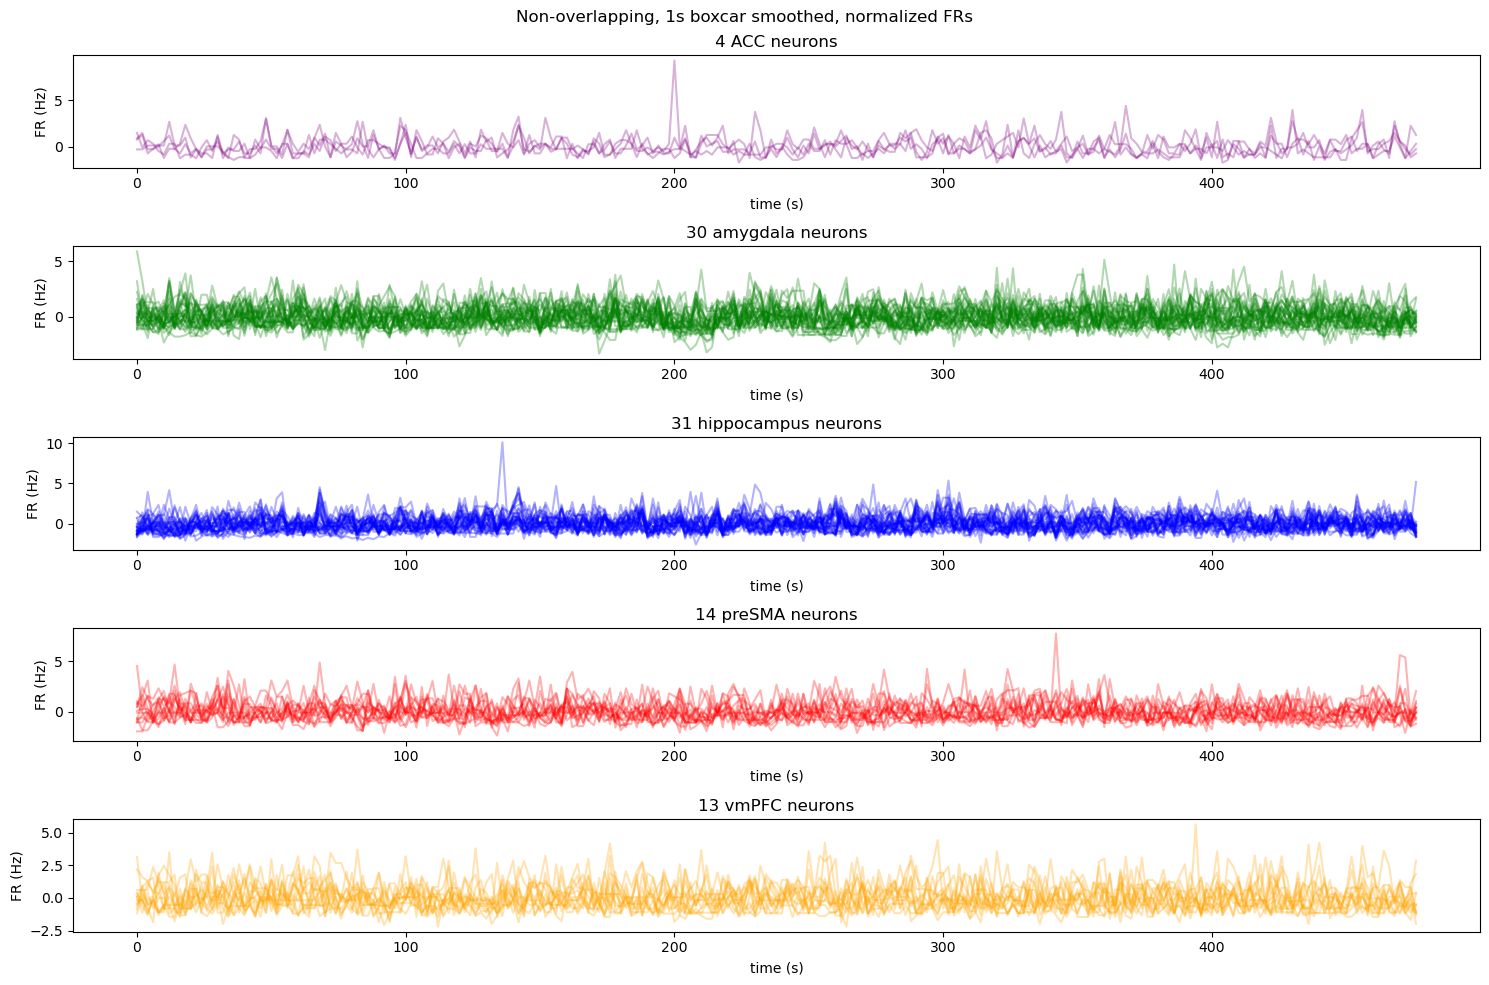

In [30]:
subj_df = df_encoding[df_encoding['sess'] == 'P54CS_R1']
fig, ax = plt.subplots(5, 1, figsize=(15, 10))
axs, ax = ax.flatten(), 0
fig.suptitle('Non-overlapping, 1s boxcar smoothed, normalized FRs')
colors = ['purple', 'green', 'blue', 'red', 'orange']

for region, region_df in subj_df.groupby('region'):
    
    for row, neur in region_df.iterrows():
        axs[ax].plot(t_box, neur['boxcar_smooths'], color=colors[ax], alpha=0.3)  # alpha to reduce overplotting

    axs[ax].set_title(f'{len(region_df)} {region} neurons')
    axs[ax].set_xlabel('time (s)')
    axs[ax].set_ylabel('FR (Hz)')
    ax += 1

plt.tight_layout()
plt.show()


## load suspense ratings, stretch it out to the entire time window, also obtain a differential of suspense

kernal thats being slid over: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


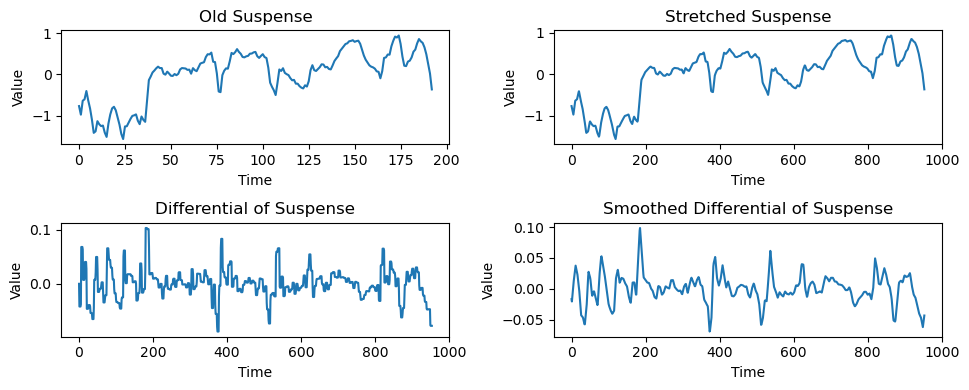

In [21]:
# 1. load suspense ratings, which are sampled every few seconds
old_suspense = np.load('./data_files/avg_suspense.npy')

# 2. stretch suspense, via interpolation, to match the movie length
old_ts, expanded_ts = np.linspace(0, 1, len(old_suspense)), np.linspace(0, 1, len(df_encoding['gauss_smooths'].iloc[0]))
suspense_interpolate_fn = interp1d(old_ts, old_suspense, kind='linear', fill_value="extrapolate")
stretched_suspense = suspense_interpolate_fn(expanded_ts)

# normalize stretched suspense to 

# 3. obtain differential of suspense
diff_suspense = np.diff(stretched_suspense)
diff_suspense = np.insert(diff_suspense, 0, 0)

# 4. smooth the differential using a moving average
smooth_diff_suspense = np.convolve(diff_suspense, np.ones(10) / 10, mode='same')
print(f'kernal thats being slid over: {np.ones(10) / 10}')

# plot
fig, axs = plt.subplots(2, 2, figsize=(10, 4))

titles = ['Old Suspense', 'Stretched Suspense', 'Differential of Suspense', 'Smoothed Differential of Suspense']
ts_data = [old_suspense, stretched_suspense, diff_suspense, smooth_diff_suspense]

for ax, title, values in zip(axs.flat, titles, ts_data):
    ax.plot(values)
    ax.set_title(title)
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')

plt.tight_layout()
plt.show()

## neuron tuning to suspense

In [22]:
# store each neurons corr & pval with suspense
corrs, pvals = [], []
suspense_df = df_encoding[['neuron', 'region', 'gauss_smooths']].copy()

for _, neur in df_encoding.iterrows():
    corr, pval = pearsonr(stretched_suspense, neur['gauss_smooths'])
    corrs.append(corr)
    pvals.append(pval)

suspense_df['suspense_corr'] = corrs
suspense_df['suspense_pval'] = pvals
suspense_df = suspense_df[(suspense_df['suspense_pval'] < 0.001) & (abs(suspense_df['suspense_corr']) > .3)].reset_index(drop=True)
suspense_df = suspense_df.sort_values(by='suspense_corr', ascending=False).reset_index(drop=True)
print(suspense_df['region'].value_counts())
suspense_df.head()


region
amygdala       87
preSMA         57
ACC            47
hippocampus    44
vmPFC          31
Name: count, dtype: int64


,neuron,region,gauss_smooths,suspense_corr,suspense_pval
0,P54CS_R2_16_4_3508_8,preSMA,"[-2.1503869142302996, -2.1394437163548363, -2....",0.839049,6.629577e-254
1,P62CS_R1_29_5_8526_3,amygdala,"[-1.3766862736348693, -1.3830728308586435, -1....",0.801404,1.030107e-214
2,P54CS_R1_32_2_15313_2,hippocampus,"[-0.5788177429097535, -0.5745854583646685, -0....",0.716645,3.753525e-151
3,P43CS_R1_58_1_1835_1,hippocampus,"[-1.8681853114572653, -1.8717179006164528, -1....",0.713420,3.366617e-149
4,P54CS_R1_29_1_5361_2,hippocampus,"[-0.7399077501282338, -0.7399474194425538, -0....",0.698907,9.771143e-141


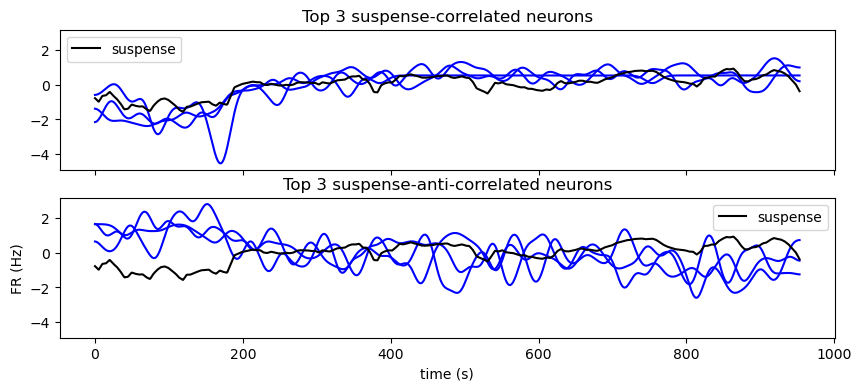

In [32]:
# stack FRs to get min and max
num_plots_neurs = 3
all_frs = np.stack(suspense_df['gauss_smooths'][:num_plots_neurs].values)
fr_min, fr_max = all_frs.min(), all_frs.max()

# scale suspense
suspense_scaled = (stretched_suspense - stretched_suspense.min()) / (stretched_suspense.max() - stretched_suspense.min())
suspense_scaled = suspense_scaled * (fr_max - fr_min) + fr_min

fig, axs = plt.subplots(2, 1, figsize=(10, 4), sharex=True, sharey=True)
axs, ax = axs.flatten(), 0

for _, neur in suspense_df[:num_plots_neurs].iterrows():
    axs[ax].plot(neur['gauss_smooths'], linestyle='-', color='blue')
axs[ax].plot(stretched_suspense, linestyle='-', color='black', label='suspense')
axs[ax].legend()
axs[ax].set_title('Top 3 suspense-correlated neurons')
ax += 1

for _, neur in suspense_df[-num_plots_neurs:].iterrows():
    axs[ax].plot(neur['gauss_smooths'], linestyle='-', color='blue')
axs[ax].plot(stretched_suspense, linestyle='-', color='black', label='suspense')
axs[ax].legend()
axs[ax].set_title('Top 3 suspense-anti-correlated neurons')
ax += 1

plt.xlabel('time (s)')
plt.ylabel('FR (Hz)')
plt.show()


## autocorrelation of sigfig neurons

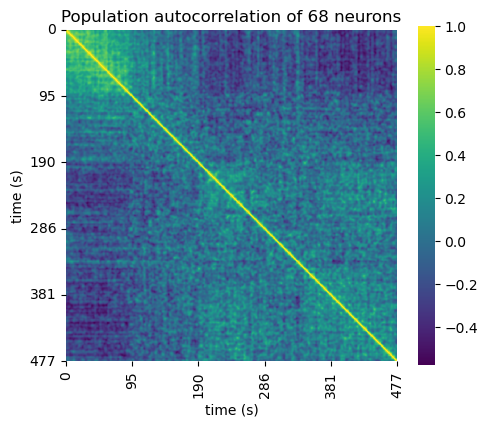

In [108]:
neur_by_time = np.stack(suspense_df['gauss_smooths'].values)
time_by_neur = neur_by_time.T  
# create t-t correlation of sigfig amyg neurons
corr_matrix = np.corrcoef(time_by_neur)

plt.figure(figsize=(5, 5))
sns.heatmap(corr_matrix, cmap='viridis', square=True, cbar_kws={'shrink': 0.75})

n_ticks = 6  # adjust number of ticks if needed
tick_locs = np.linspace(0, corr_matrix.shape[0], n_ticks)
tick_labels = np.linspace(0, 477, n_ticks, dtype=int)
plt.xticks(tick_locs, tick_labels)
plt.yticks(tick_locs, tick_labels)

plt.title(f'Population autocorrelation of {time_by_neur.shape[1]} neurons')
plt.xlabel('time (s)')
plt.ylabel('time (s)')
plt.tight_layout()
plt.show()

## neuron & time predictors of suspense

(467, 500) (467,)


/Users/f0064z8/anaconda3/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)


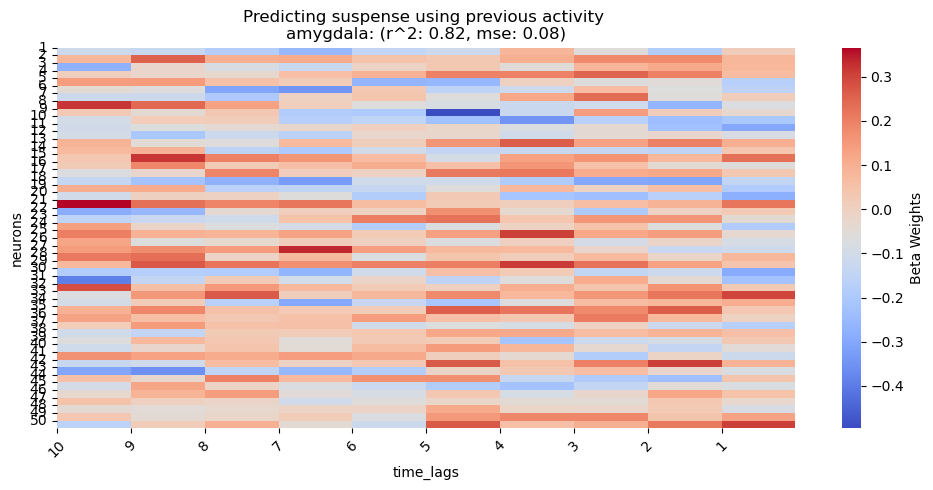

In [10]:
max_lag = 10
features, labels = [], []

for y_t in range(max_lag, len(stretched_suspense)):
    
    features.append(neur_by_time[:, y_t-max_lag: y_t].flatten())
    labels.append(stretched_suspense[y_t])

features, labels = np.array(features), np.array(labels)

# normalize features
scaler_X = MinMaxScaler()
features = scaler_X.fit_transform(features)

print(features.shape, labels.shape)
# t*N and t*1 respectively
# t= 477-max_lag, N = neur_by_time.shape[0]*max_lag

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

glm = GLM(y_train, X_train, family=Gaussian())
reg = glm.fit()
weights, y_pred = reg.params, reg.predict(X_test)
mse, r2 = mean_squared_error(y_test, y_pred), r2_score(y_test, y_pred)

# reshape beta weights to neuron * time
weights_mtx = weights.reshape((neur_by_time.shape[0], max_lag))

fig = plt.figure(figsize=(10, 5))
sns.heatmap(weights_mtx, cmap='coolwarm', cbar_kws={'label': 'Beta Weights'})
plt.xlabel('time_lags')
plt.xticks(range(max_lag), range(max_lag, 0, -1), rotation=45)
plt.ylabel('neurons')
plt.yticks(range(neur_by_time.shape[0]), list(range(1, neur_by_time.shape[0]+1)))
plt.title(f'Predicting suspense using previous activity \n{region}: (r^2: {r2:.2f}, mse: {mse:.2f})')
plt.tight_layout()
plt.show()


## neuron & time predictors of avg neuron activity

(467, 500) (467,)


/Users/f0064z8/anaconda3/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)


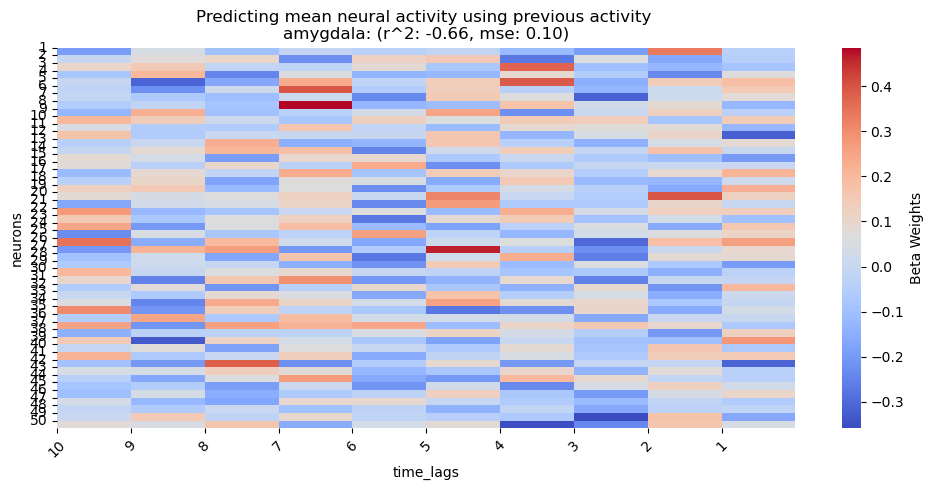

In [11]:
features, labels = [], []

for y_t in range(max_lag, len(stretched_suspense)):
    
    features.append(neur_by_time[:, y_t-max_lag: y_t].flatten())
    labels.append(np.median(neur_by_time[:, y_t]))

features, labels = np.array(features), np.array(labels)

# normalizing features
scaler_X = MinMaxScaler()
features = scaler_X.fit_transform(features)

print(features.shape, labels.shape)
# t*N and t, respectively
# t= 477-max_lag = 467, N = 24*max_lag = 240

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

glm = GLM(y_train, X_train, family=Gaussian())
reg = glm.fit()
weights, y_pred = reg.params, reg.predict(X_test)
mse, r2 = mean_squared_error(y_test, y_pred), r2_score(y_test, y_pred)

# reshape beta weights to neuron * time
weights_mtx = weights.reshape((neur_by_time.shape[0], max_lag))

fig = plt.figure(figsize=(10, 5))
sns.heatmap(weights_mtx, cmap='coolwarm', cbar_kws={'label': 'Beta Weights'})
plt.xlabel('time_lags')
plt.xticks(range(max_lag), range(max_lag, 0, -1), rotation=45)
plt.ylabel('neurons')
plt.yticks(range(neur_by_time.shape[0]), list(range(1, neur_by_time.shape[0]+1)))
plt.title(f'Predicting mean neural activity using previous activity \n{region}: (r^2: {r2:.2f}, mse: {mse:.2f})')
plt.tight_layout()
plt.show()


## acf

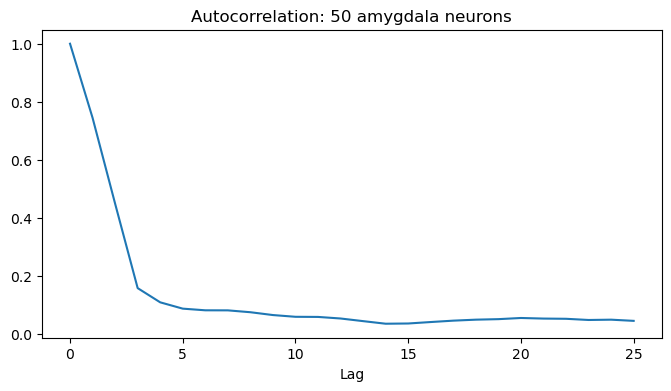

In [12]:
lags = 25
acfs = []

for i in range(neur_by_time.shape[0]):
    acfs.append(acf(neur_by_time[i], nlags=lags))

acfs = np.array(acfs)

plt.figure(figsize=(8, 4))
plt.plot(np.mean(acfs, axis=0))
plt.xlabel('Lag')
plt.title(f'Autocorrelation: {neur_by_time.shape[0]} {region} neurons')
plt.show()

## gerald plot

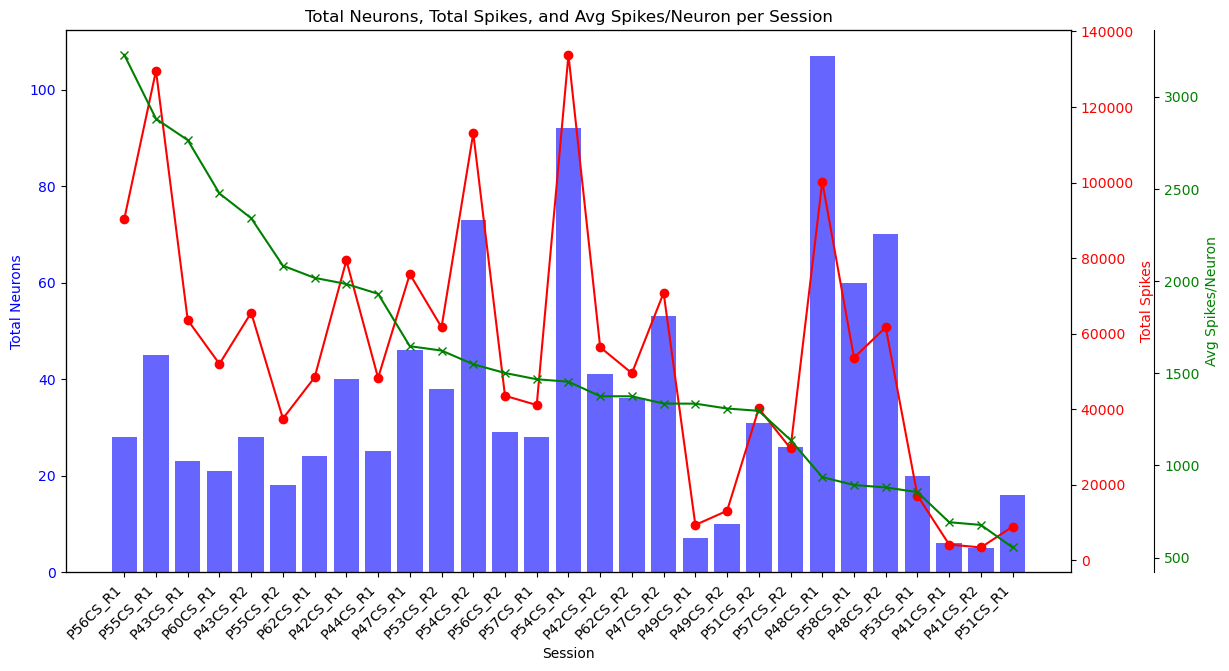

In [ ]:
# Group by session and calculate total neurons, total spikes, and average spikes per neuron
session_stats = df_encoding.groupby('sess').agg(
    total_neurons=('neuron', 'nunique'),
    total_spikes=('trial_aligned_spikes', lambda x: np.sum([len(spikes) for spikes in x]))
).reset_index()

# Calculate average spikes per neuron
session_stats['avg_spikes_per_neuron'] = session_stats['total_spikes'] / session_stats['total_neurons']

# Sort by average spikes per neuron
session_stats = session_stats.sort_values(by='avg_spikes_per_neuron', ascending=False)

# Plot the results
fig, ax = plt.subplots(figsize=(12, 6))

# Bar plot for total neurons
ax.bar(session_stats['sess'], session_stats['total_neurons'], color='b', alpha=0.6, label='Total Neurons')

# Line plot for total spikes on a secondary y-axis
ax2 = ax.twinx()
ax2.plot(session_stats['sess'], session_stats['total_spikes'], color='r', marker='o', label='Total Spikes')

# Line plot for average spikes per neuron on a secondary y-axis
ax3 = ax.twinx()
ax3.spines['right'].set_position(('outward', 60))  # Offset the third axis
ax3.plot(session_stats['sess'], session_stats['avg_spikes_per_neuron'], color='g', marker='x', label='Avg Spikes/Neuron')

# Add legends and title
fig.tight_layout()
ax.set_xlabel('Session')
ax.set_ylabel('Total Neurons', color='b')
ax2.set_ylabel('Total Spikes', color='r')
ax3.set_ylabel('Avg Spikes/Neuron', color='g')
ax.tick_params(axis='y', labelcolor='b')
ax2.tick_params(axis='y', labelcolor='r')
ax3.tick_params(axis='y', labelcolor='g')

# Rotate x-tick labels
ax.set_xticks(range(len(session_stats['sess'])))
ax.set_xticklabels(session_stats['sess'], rotation=45, ha='right')

plt.title('Total Neurons, Total Spikes, and Avg Spikes/Neuron per Session')
plt.show()

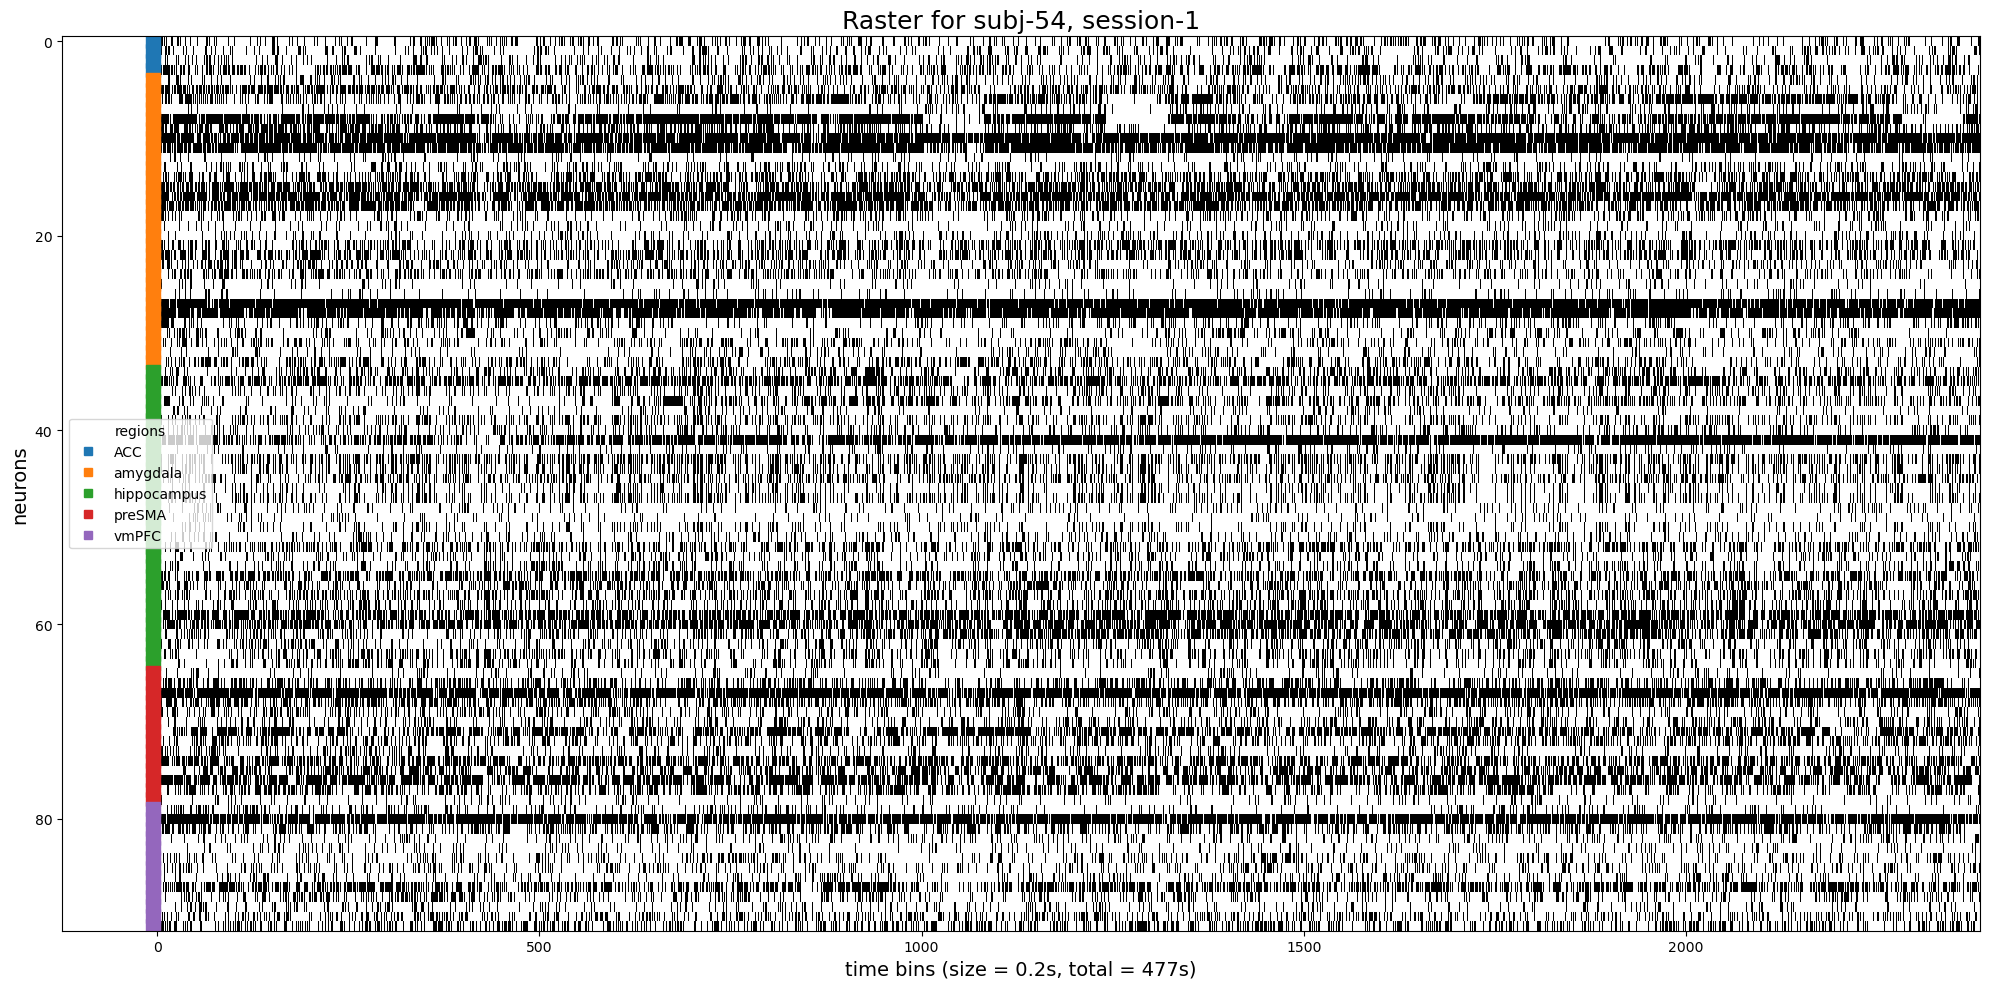

In [ ]:
from matplotlib.lines import Line2D

# pick some colors for your regions
unique_regions = np.unique(regions_sorted)
region_colors = {r: c for r, c in zip(unique_regions, plt.cm.tab10.colors)}
region_color_list = [region_colors[r] for r in regions_sorted]

plt.figure(figsize=(20, 10))

# grayscale raster
plt.imshow(neur_by_time_sorted, aspect='auto', cmap='Greys', interpolation='nearest')

# colored square on the left of each neuron
for i, color in enumerate(region_color_list):
    plt.plot([-5], [i], marker='s', color=color, markersize=10)

# legend
for region, color in region_colors.items():
    plt.plot([], [], color=color, marker='s', linestyle='none', label=region)
plt.legend(title='regions', loc='center left')

plt.xlabel(f'time bins (size = {bin_size}s, total = 477s)', fontsize=14)
plt.ylabel('neurons', fontsize=14)
plt.title(f'Raster for subj-{session[1:3]}, session-{session[-1]}', fontsize=18)
plt.tight_layout()
plt.show()


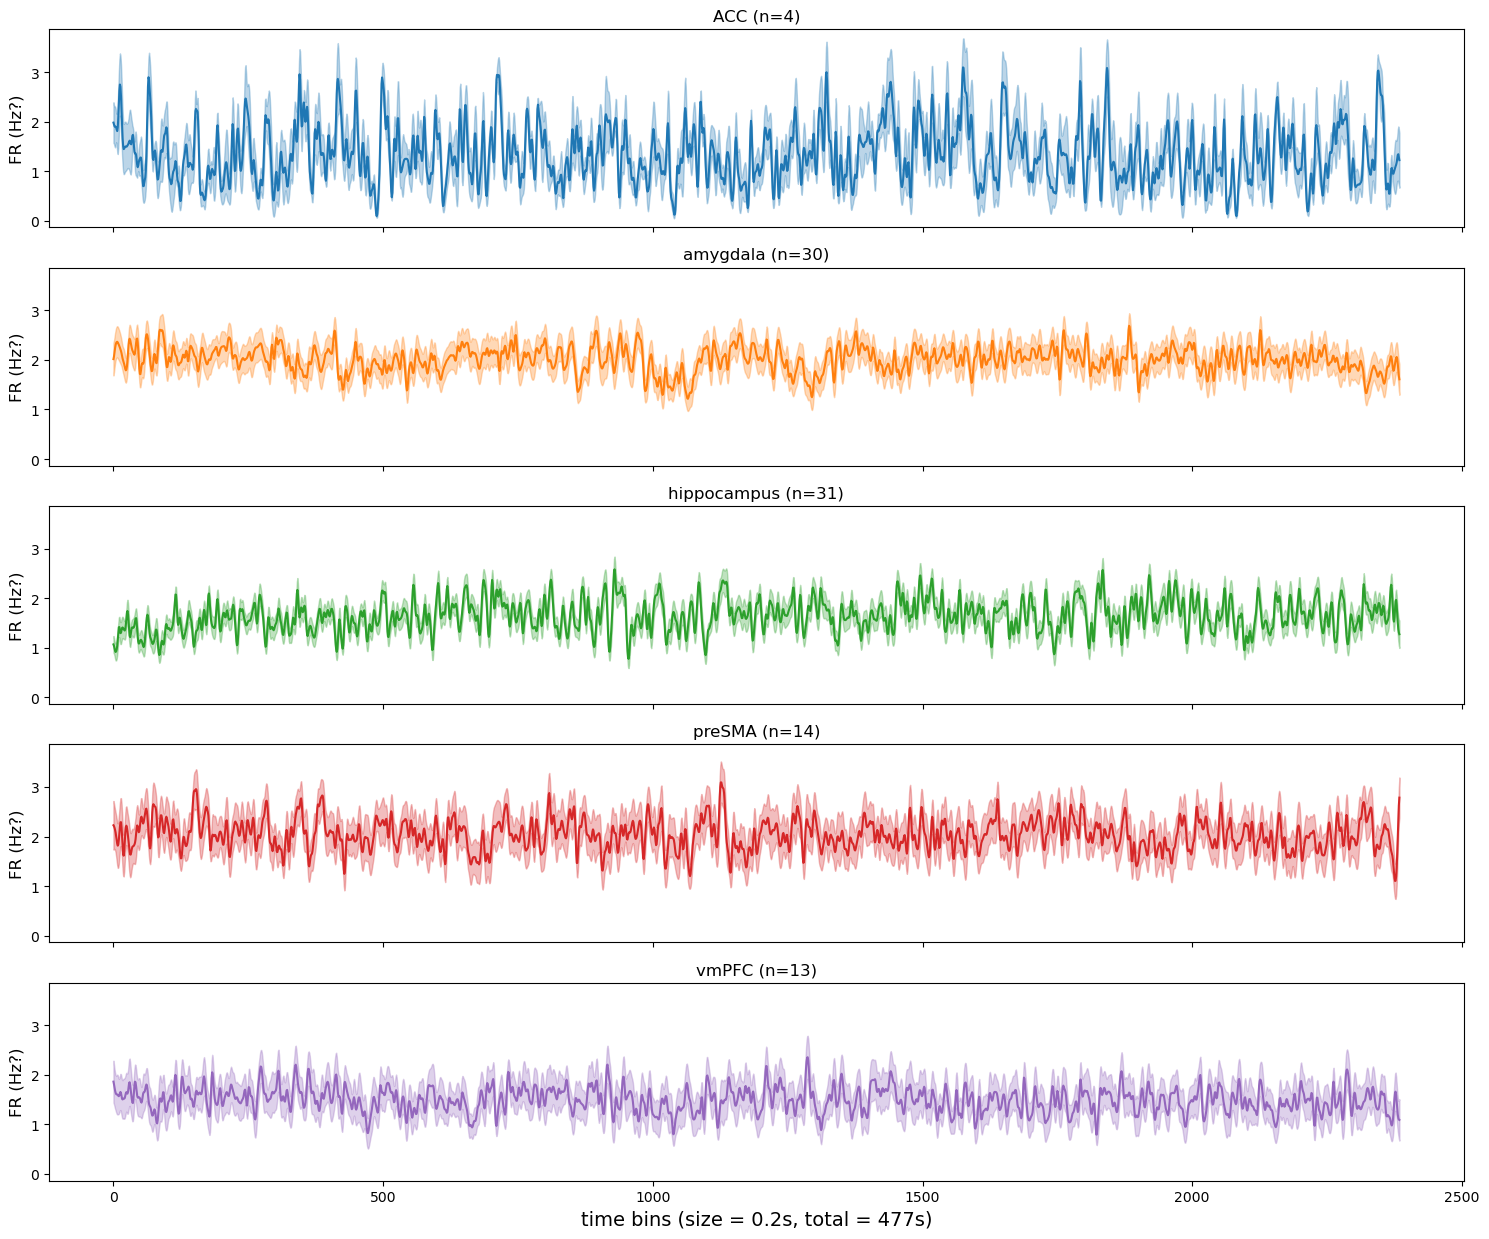

In [ ]:
from scipy.ndimage import gaussian_filter1d

# smooth FR per neuron
smoothed_fr = gaussian_filter1d(neur_by_time, sigma=2, axis=1)

# convert to Hz by dividing by bin size
smoothed_fr_hz = smoothed_fr / bin_size

# group by region
region_means = {}
region_sems = {}

for region in np.unique(regions):
    idx = np.where(regions == region)[0]
    region_data = smoothed_fr_hz[idx]
    region_means[region] = region_data.mean(axis=0)
    region_sems[region] = region_data.std(axis=0) / np.sqrt(len(idx))

# plot subplots by region
fig, axs = plt.subplots(len(region_means), 1, figsize=(15, 2.5 * len(region_means)), sharex=True, sharey=True)

for ax, region in zip(axs, region_means):
    mean_fr = region_means[region]
    sem = region_sems[region]
    ax.plot(mean_fr, color=region_colors[region], label=region)
    ax.fill_between(np.arange(n_bins), mean_fr - sem, mean_fr + sem, color=region_colors[region], alpha=0.3)
    ax.set_title(f'{region} (n={np.sum(regions==region)})', fontsize=12)
    ax.set_ylabel('FR (Hz?)', fontsize=12)

axs[-1].set_xlabel(f'time bins (size = {bin_size}s, total = 477s)', fontsize=14)
plt.tight_layout()
plt.show()


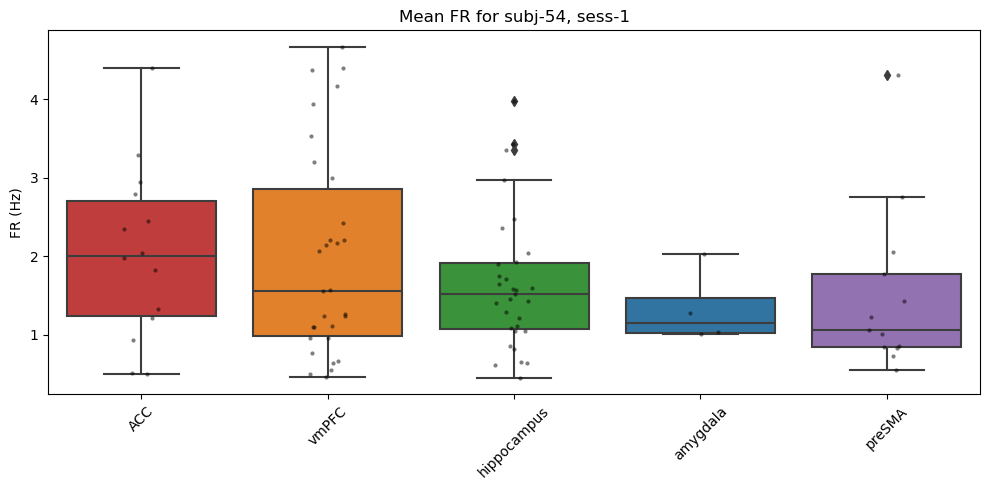

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# compute per-neuron mean firing rate (in Hz)
mean_fr_per_neuron = neur_by_time.mean(axis=1) / bin_size

# create a dataframe to group and plot
fr_df = pd.DataFrame({
    'region': regions,
    'mean_fr_hz': mean_fr_per_neuron
})

# boxplot to visualize
plt.figure(figsize=(10, 5))
sns.boxplot(data=fr_df, x='region', y='mean_fr_hz', palette=region_colors)
sns.stripplot(data=fr_df, x='region', y='mean_fr_hz', color='black', size=3, jitter=True, alpha=0.5)
plt.ylabel('FR (Hz)')
plt.xlabel('')
plt.title(f'Mean FR for subj-{session[1:3]}, sess-{session[-1]}')
plt.xticks(rotation=45)

# reorder x-axis by mean FR (ascending)
ordered_regions = fr_df.groupby('region')['mean_fr_hz'].mean().sort_values().index
plt.xticks(ticks=range(len(ordered_regions)), labels=ordered_regions, rotation=45)

plt.tight_layout()
plt.show()


## inspecting a particular session

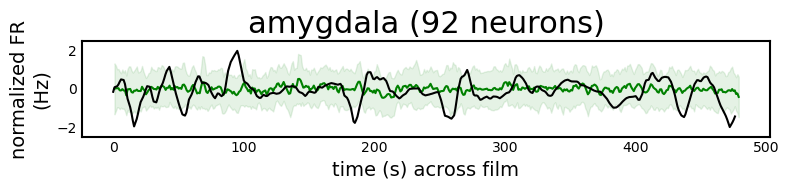

In [ ]:
session = 'P54CS_R1'

select_df = df_encoding[df_encoding['sess'] == session].reset_index(drop=True)

# get population time series, and mean & sd
neur_by_time = np.array(select_df['trial_smooth_spikes'].tolist())
neur_by_time_avg, neur_by_time_sd = np.nanmean(neur_by_time, axis=0), np.nanstd(neur_by_time, axis=0) 

fig = plt.figure(figsize=(8, 2))
plt.plot(x_time_points, neur_by_time_avg, label=region, color=color_map.get(region))
plt.fill_between(x_time_points,
                 neur_by_time_avg - neur_by_time_sd, neur_by_time_avg + neur_by_time_sd,
                 alpha=.1, color=color_map.get(region))

# plot suspense
min_fr, max_fr = -2, 2 #np.nanmin(neur_by_time_avg), np.nanmax(neur_by_time_avg)

normalized_suspense = (stretched_suspense - np.min(stretched_suspense)) / (np.max(stretched_suspense) - np.min(stretched_suspense)) * (max_fr - min_fr) + min_fr
# plt.plot(normalized_suspense, label='suspense', color='black')

# # now plot normalized_diff_supsense too
normed_smooth_diff_suspense = (smooth_diff_suspense - np.min(smooth_diff_suspense)) / (np.max(smooth_diff_suspense) - np.min(smooth_diff_suspense)) * (max_fr - min_fr) + min_fr
plt.plot(normed_smooth_diff_suspense, label='diff_suspense', color='black')

# plt.legend(loc='upper left')
plt.xlabel('time (s) across film', fontsize=14)#, fontname='Arial')
plt.ylabel('normalized FR\n(Hz)', fontsize=14)#, fontname='Arial')
plt.ylim(min_fr-.5, max_fr+.5)
plt.tick_params(axis='both', length=0)
for spine in plt.gca().spines.values():
    spine.set_linewidth(1.5)
plt.title(f'{region} ({neur_by_time.shape[0]} neurons)', fontsize=22)
plt.tight_layout()
plt.savefig(f'data_files/{session}_{region}_{neur_by_time.shape[0]}_neurons.svg', format='svg', dpi=300)
plt.show()

# plot individual neurons
# fig, axs = plt.subplots(neur_by_time.shape[0], 1, figsize=(10, 20))

# for i in range(neur_by_time.shape[0]):
#     axs[i].plot(x_time_points, neur_by_time[i], label=f'Neuron {i+1}')
#     axs[i].set_title(f'Time Series of Neuron {i+1}')
#     axs[i].set_ylim(-2, max(4, max(neur_by_time[i])))

# plt.tight_layout()
# plt.show()

## for each subject's 2 sessions, plot region-avged FRs

In [ ]:
# regions_to_plot = ['amygdala']

# for subj, subj_df in df_encoding.groupby('subj'):

#     if not subj_df['region'].str.contains('|'.join(regions_to_plot)).any():
#         continue

#     fig, axs = plt.subplots(2, 1, figsize=(10, 4))
#     sess_num = 0

#     for session, session_df in subj_df.groupby('sess'):

#         # if not session in sessions_with_scene_cells:
#         #     continue

#         sess_minFR, sess_maxFR = 0, 0
#         print()
#         for region, region_df in session_df.groupby('region'):

#             if not region in regions_to_plot:
#                 continue

#             # convert groupby obj to 2d arr
#             smooth_spikes_arr = np.array(region_df['trial_smooth_spikes'].tolist())

#             # get the avg and std smoothed FR across neurons of a region  
#             smooth_FR_region_avg, smooth_FR_region_sd = np.nanmean(smooth_spikes_arr, axis=0), np.nanstd(smooth_spikes_arr, axis=0)

#             # to set ylim for plotting purposes, get the max and min FR across all regions
#             across_rgn_minFR = min(sess_minFR, np.nanmin(smooth_FR_region_avg))
#             across_rgn_maxFR = max(sess_maxFR, np.nanmax(smooth_FR_region_avg))

#             # plot FR
#             axs[sess_num].plot(x_time_points, smooth_FR_region_avg, label=region, color=color_map.get(region))
#             axs[sess_num].fill_between(x_time_points,
#                                        smooth_FR_region_avg - smooth_FR_region_sd, smooth_FR_region_avg + smooth_FR_region_sd,
#                                        alpha=0.1, color=color_map.get(region))

#             # plot suspense
#             # normalized_suspense = (suspense_ts - np.min(suspense_ts)) / (np.max(suspense_ts) - np.min(suspense_ts)) * (across_rgn_maxFR - across_rgn_minFR) + across_rgn_minFR
#             # axs[sess_num].plot(np.linspace(0, np.max(df_encoding['RT']), len(suspense_ts)), normalized_suspense, label='suspense', color='black')

#             normalized_suspense = (stretched_suspense - np.min(stretched_suspense)) / (np.max(stretched_suspense) - np.min(stretched_suspense)) * (across_rgn_maxFR - across_rgn_minFR) + across_rgn_minFR
#             axs[sess_num].plot(normalized_suspense, label='suspense', color='black')

#         # # make vertical lines at each scene cut
#         # for cut, color in zip(cuts_df['shot_start_t'], cuts_df['cut_colors']):
#         #     axs[sess_num].axvline(x=cut, color=color, linestyle='--')

#         if False: #subj in no_fMRI_subjs:
#             axs[sess_num].set_title(f'subj-{subj} sessions (DID NOT UNDERGO fMRI)', fontsize=16)
#         else:
#             axs[sess_num].set_title(f'subj-{subj} session {session.split("R")[1][0]} ({smooth_spikes_arr.shape[0]} neurons)', fontsize=16)

#         axs[sess_num].set_xlabel('time (s) across film', fontsize=12)
#         axs[sess_num].set_ylabel('normalized FR', fontsize=12)
#         axs[sess_num].set_ylim(across_rgn_minFR, across_rgn_maxFR)
#         axs[sess_num].legend(loc='upper right')

#         sess_num += 1

#     plt.tight_layout()  
#     plt.show()



## PCA as a function of suspense

In [ ]:
# region = 'preSMA'
# df_region = df_encoding[df_encoding['region'] == region]
# sess_num = 0

# suspense_ranked = stats.rankdata(stretched_suspense)
# diff_suspense_ranked = stats.rankdata(smooth_diff_suspense)

# for session, session_df in df_region.groupby('sess'):

#     if len(session_df) < 5:
#         continue

#     subj = session.split('CS')[0]

#     # convert groupby obj to 2d arr
#     neur_by_time = np.array(session_df['trial_smooth_spikes'].tolist())

#     # peform PCA
#     pca = PCA(n_components=3)  # start with a few PCs
#     pc_scores = pca.fit_transform(neur_by_time.T) # get time by neuron

#     # # apply PHATE on PCA-reduced data
#     # phate_operator = phate.PHATE(n_components=3, verbose=False)  # Set to 3 components for 3D
#     # phate_embedding = phate_operator.fit_transform(pc_scores)

#     fig, axs = plt.subplots(1, 2, figsize=(10, 4), subplot_kw={'projection': '3d'})
#     suspense_vars, suspense_titles = [suspense_ranked, smooth_diff_suspense], ['ranked suspense', 'diff suspense']

#     for i in range(2):
        
#         # could alternatively plot phate_embeddings
#         scatter = axs[i].scatter(
#             pc_scores[:, 0], pc_scores[:, 1], pc_scores[:, 2],
#             c=suspense_vars[i], cmap="coolwarm"
#         )
#         axs[i].set_title(f"{session}-{region}\nColored by {suspense_titles[i]}")
#         axs[i].set_xlabel("PC/phate 1")
#         axs[i].set_ylabel("PC/phate 2")
#         axs[i].set_zlabel("PC/phate 3")

#         # plt.colorbar(scatter, ax=axs[ax_i], label=suspence_title, shrink=0.5)

#     plt.tight_layout()
#     plt.show()

#     sess_num += 1
#     break




## autocorrelation as a function of suspense 

In [ ]:
# region = 'ACC'
# df_region = df_encoding[df_encoding['region'] == region]
# sess_num = 0

# for session, session_df in df_region.groupby('sess'):

#     if len(session_df) < 5:
#         continue

#     subj = session.split('CS')[0]

#     # convert groupby obj to 2d array
#     neur_by_time = np.array(session_df['trial_smooth_spikes'].tolist())  # shape: (n_neurons, n_timepoints)

#     # calculate autocorrelation across time for neural population activity
#     autocorr = [.5] # iniitalize with 1 value
#     for lag in range(neur_by_time.shape[1]-1):
#         corr = np.corrcoef(neur_by_time[:, lag].ravel(), neur_by_time[:, lag+1].ravel())[0, 1]
#         autocorr.append(corr)

#     # smooth autocorrelation
#     valid_autocorr = np.convolve(autocorr, np.ones(10) / 10, mode='valid')

#     # Add edge values manually (e.g., duplicate the first and last values)
#     start = [valid_autocorr[0]] * 5  # Repeat first value for the start
#     end = [valid_autocorr[-1]] * 4    # Repeat last value for the end

#     autocorr = np.concatenate([start, valid_autocorr, end])
#     print(len(autocorr), len(x_time_points))

#     # normalize suspense
#     min_autocorr, max_autocorr = np.min(autocorr), np.max(autocorr)
#     normed_suspense = (stretched_suspense - np.min(stretched_suspense)) / (np.max(stretched_suspense) - np.min(stretched_suspense)) * (max_autocorr - min_autocorr) + min_autocorr
#     normed_diff_suspense = (smooth_diff_suspense - np.min(smooth_diff_suspense)) / (np.max(smooth_diff_suspense) - np.min(smooth_diff_suspense)) * (max_autocorr - min_autocorr) + min_autocorr

#     fig, axs = plt.subplots(1, 2, figsize=(20, 2))

#     for i in range(2):
#         axs[i].plot(x_time_points, autocorr, label='autocorr', color='black')
#         axs[i].plot(x_time_points,
#                     [normed_suspense, normed_diff_suspense][i],
#                     label=['suspense', 'diff suspense'][i],
#                     color=['red', 'green'][i])
#         axs[i].set_title(f'{session}-{region}')
#         axs[i].set_xlabel("movie time (s)")
#         axs[i].set_ylim(min_autocorr, max_autocorr)
#         axs[i].legend(loc='upper left')

#     plt.tight_layout()
#     plt.show()

#     sess_num += 1
    
#     break


## sliding window PCA to plot % explained by top PCs

In [ ]:
# df_region = df_encoding[df_encoding['region'] == 'amygdala']
# win_size = 5

# for session, session_df in df_region.groupby('sess'):

#     if len(session_df) < 5: # only consider sessions with >5 neurons in region
#         continue

#     # convert groupby obj to 2d array
#     neur_by_time = np.array(session_df['trial_smooth_spikes'].tolist())
#     num_neurons, num_timepoints = neur_by_time.shape

#     var_explained_by_top_PCs = []
#     # slide window
#     for start in range(0, num_timepoints - win_size + 1):

#         window_data = neur_by_time[:, start:start + win_size]
        
#         pca = PCA()
#         pca.fit(window_data.T)
        
#         # append % explained by top 2 PCs
#         var_explained_by_top_PCs.append(np.sum(np.sort(pca.explained_variance_ratio_)[-1:]))

#     var_explained_by_top_PCs = np.convolve(var_explained_by_top_PCs, np.ones(3)/3, mode='same')

#     min_var, max_var = np.min(var_explained_by_top_PCs), np.max(var_explained_by_top_PCs)
#     normed_suspense = (stretched_suspense - np.min(stretched_suspense)) / (np.max(stretched_suspense) - np.min(stretched_suspense)) * (max_var - min_var) + min_var
#     normed_smooth_diff_suspense = (smooth_diff_suspense - np.min(smooth_diff_suspense)) / (np.max(smooth_diff_suspense) - np.min(smooth_diff_suspense)) * (max_var - min_var) + min_var

#     plt.figure(figsize=(10, 1))
#     plt.plot(normed_smooth_diff_suspense, label='suspense', color='black')

#     timepoints = np.arange(0, num_timepoints - win_size + 1) 
#     plt.plot(timepoints, var_explained_by_top_PCs, color='blue', label="Variance Explained by Top 3 Neurons")

#     plt.xlabel('movie time (s)')
#     plt.ylabel('% explained by\ntop PCs')
#     plt.ylim(min_var, max_var)
#     # plt.legend()
#     plt.title(f'{session}')
#     plt.show()


## neurons sorted by PCA

In [ ]:
# [10  4 11  1  6  5  9  3  0  7  8 12  2] # sess_baseline
# [ 2  9  5  0  6  8  1  3  7  4 12 10 11] # shortest_baseline
# [ 5  1  9  4  8 10  3  6 11  0  7 12  2] # self


## get scene cut info

In [11]:
# 1. all cuts
cuts_df = pd.read_csv('../assets/annotations/scenecut_info.csv')
cuts = cuts_df['shot_start_t'].tolist()
print(f'{len(cuts)} total cuts, at indices {cuts}')

# 2. scene cuts
scene_cut_inds = [0] # 1st frame is always a scene cut
scene_cut_inds.extend(np.where(np.diff(cuts_df['scene_id']) != 0)[0] + 1)
scene_cuts = [cuts[i] for i in scene_cut_inds]
print(f'{len(scene_cuts)} scene cuts at t: {scene_cuts}')

# 3. color code all & scene cuts
cuts_df['cut_colors'] = 'grey'
cuts_df.loc[scene_cut_inds, 'cut_colors'] = 'red'
cuts_df.head(15)

93 total cuts, at indices [0.0, 4.72, 15.0, 16.72, 19.08, 21.72, 25.08, 27.08, 37.64, 46.16, 66.28, 66.8, 90.16, 92.72, 94.88, 99.32, 103.64, 108.28, 113.44, 115.0, 117.96, 120.0, 121.88, 126.52, 129.2, 137.56, 140.36, 143.36, 145.24, 147.88, 149.4, 150.76, 153.4, 153.92, 159.08, 161.16, 163.08, 167.28, 169.04, 170.68, 171.84, 173.48, 184.92, 211.6, 217.48, 254.24, 256.12, 261.6, 264.84, 266.68, 269.24, 273.04, 277.28, 281.28, 284.56, 288.76, 291.44, 307.88, 314.48, 328.52, 340.76, 346.2, 350.0, 357.84, 360.0, 362.56, 364.92, 367.76, 369.44, 371.64, 389.64, 407.88, 409.72, 419.04, 420.24, 424.36, 427.64, 428.72, 431.52, 433.48, 435.0, 437.52, 439.6, 442.28, 445.24, 450.04, 451.4, 453.04, 453.88, 456.44, 456.96, 459.32, 475.44]
13 scene cuts at t: [0.0, 27.08, 37.64, 46.16, 66.8, 184.92, 254.24, 314.48, 328.52, 340.76, 433.48, 435.0, 437.52]


,scene_id,shot_start_fr,shot_start_t,shot_dur_t,location,cut_type,cut_dur_t,cut_dur_fr,cut_colors
0,1.0,1.0,0.00,4.72,backyard,cut,0.00,0,red
1,1.0,119.0,4.72,10.28,backyard,cut,0.00,0,grey
2,1.0,376.0,15.00,1.72,backyard,cut,0.00,0,grey
3,1.0,419.0,16.72,2.36,backyard,cut,0.00,0,grey
4,1.0,478.0,19.08,2.64,backyard,cut,0.00,0,grey
5,1.0,544.0,21.72,3.36,backyard,cut,0.00,0,grey
6,1.0,628.0,25.08,2.00,backyard,cut,0.00,0,grey
7,2.0,678.0,27.08,10.56,livingroom,fadeout/fadein,0.40,10,red
8,3.0,942.0,37.64,8.52,bedroom,dissolve,0.48,12,red
9,4.0,1155.0,46.16,20.12,bedroom,cut,0.00,0,red


## plot some of the scene selective cells that they found

'Significant proportions of cells were event selective in the vmPFC (10/175, p =  0.005, permutation test) and preSMA (20/299,  p <  0.001) but not in the amygdala (15/479, p =  0.081), ACC (7/236, p =  0.224), and hippocampus (8/261, p = 0.199;  Fig. 7a,b show examples).'

plotting retained scene cells


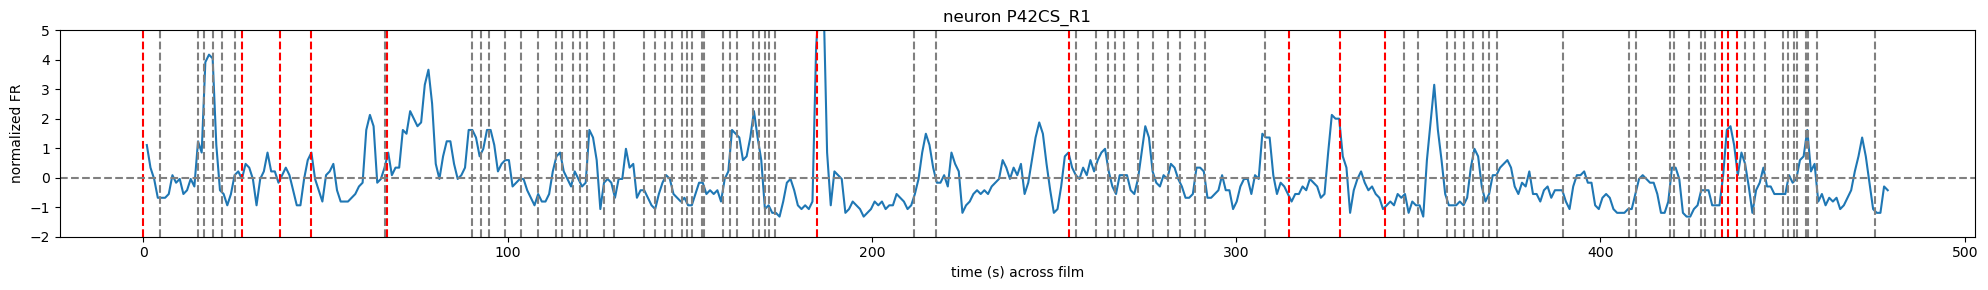

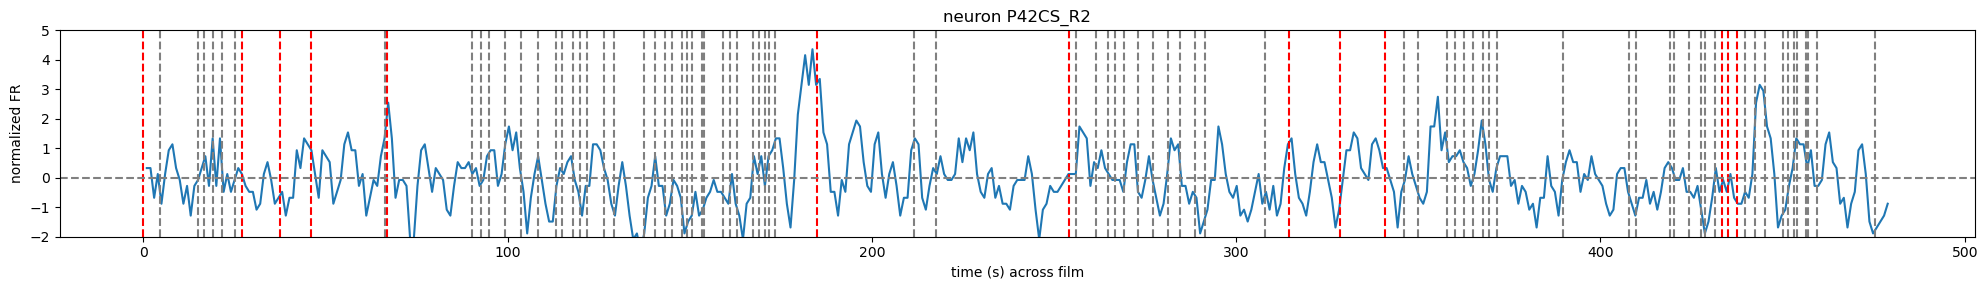

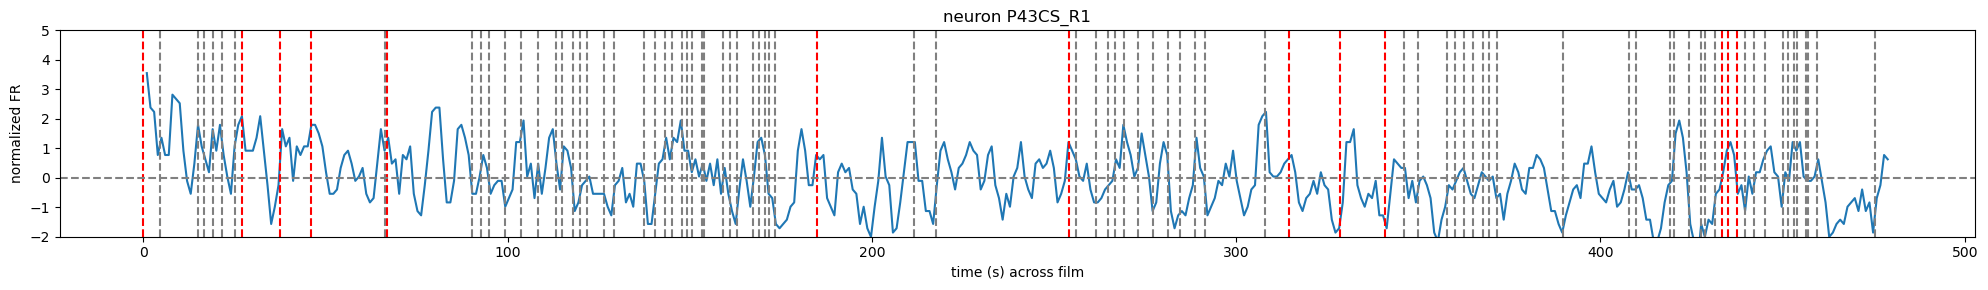

In [12]:
print('plotting retained scene cells')

for neuron in scene_cells[:3]:

    if neuron in missing_spikes_neurs or neuron in zero_FR_neurs:
        continue

    neuron_df = df_encoding[df_encoding['neuron'] == neuron]

    # for plotting, get the length of the first neuron's spike array
    num_bins = len(neuron_df['trial_smooth_spikes'].iloc[0])
    x_time_points = np.linspace(1, np.max(neuron_df['RT']), num_bins)
    # print(len(x_time_points))

    plt.figure(figsize=(20, 3))
    plt.plot(x_time_points, neuron_df['trial_smooth_spikes'].iloc[0], label=neuron)

    for cut, color in zip(cuts_df['shot_start_t'], cuts_df['cut_colors']):
        plt.axvline(x=cut, color=color, linestyle='--')

    plt.xlabel('time (s) across film')
    plt.ylabel('normalized FR')
    plt.title(f'neuron {neuron[:8]}')
    plt.ylim(-2, 5)
    plt.axhline(0, color='grey', linestyle='--')
    plt.tight_layout()
    plt.show()


## plot single session scene cut plus FR info 

In [71]:
# session, region = 'P57CS_R2', 'amygdala'

# P44CS_R1_ACC_df = df_encoding[(df_encoding['sess'] == session) & (df_encoding['region'] == region)].reset_index(drop=True)
# neur_by_time = np.array(P44CS_R1_ACC_df['trial_smooth_spikes'].tolist())
# print(neur_by_time.shape)

# neur_by_time_avg, neur_by_time_sd = np.nanmean(neur_by_time, axis=0), np.nanstd(neur_by_time, axis=0) 

# fig = plt.figure(figsize=(10, 2))
# plt.plot(x_time_points, neur_by_time_avg, label=region, color=color_map.get(region))
# plt.fill_between(x_time_points,
#                  neur_by_time_avg - neur_by_time_sd, neur_by_time_avg + neur_by_time_sd,
#                  alpha=0.1, color=color_map.get(region))

# # # make vertical lines at each scene cut
# # for cut, color in zip(cuts_df['shot_start_t'], cuts_df['cut_colors']):
# #     plt.axvline(x=cut, color=color, linestyle='--')

# plt.xlabel('time (s) across film', fontsize=12)
# plt.ylabel('normalized FR', fontsize=12)
# plt.ylim(-2, 4)
# plt.legend(loc='upper right')

# plt.tight_layout()
# plt.show()


# # convert to np array and hand select a period of FR ramp-up
# neur_by_time = np.array(P44CS_R1_ACC_df['trial_smooth_spikes'].tolist())

# pca = PCA()
# pca.fit(neur_by_time.T)

# first_pc_loadings = pca.components_[0]
# neurs_sorted_by_pc1 = np.argsort(np.abs(first_pc_loadings))[::-1]

# neur_by_time = neur_by_time[neurs_sorted_by_pc1]
# top_neur_by_time = neur_by_time[:3]

# # print(f'1st pc loadings: {first_pc_loadings}')
# # print(f'sorted neurons: {neurs_sorted_by_pc1}')
# # print(top_neur_by_time.shape)

# fig, axs = plt.subplots(top_neur_by_time.shape[0], 1, figsize=(10, 5))

# for i in range(top_neur_by_time.shape[0]):
#     axs[i].plot(top_neur_by_time[i], label = neurs_sorted_by_pc1[i])
#     axs[i].set_ylim(-2, max(4, max(top_neur_by_time[i])))
#     axs[i].legend()
# plt.tight_layout()
# plt.show()

